In [67]:
import networkx as nx 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import optimize
import scipy
import sys
from src import SingleAgent as sa
from src import helperfunctions as hf


In [83]:

import networkx as nx 
import numpy as np
import math  



from src import helperfunctions as hf


class mf_ising_system:

    def __init__(self,graph,background_field,fixed_point_iter=int(5*1e4),init_mag='random',fp_tol_fac=10-6,
        iim_iter=1000,step_size=1.0,iim_tol_fac=1e-5,momentum=0.4,optimiser_type='sgdm'):
        
        self.graph = graph
        self.adj_matrix = nx.to_numpy_matrix(graph)
        self.graph_size = len(graph.nodes.keys())
        self.background_field = background_field
        self.fixed_point_iter=fixed_point_iter
        self.iim_iter = iim_iter
        self.fp_tol_fac=fp_tol_fac
        self.iim_tol_fac=iim_tol_fac
        self.optimiser_type = optimiser_type
        self.step_size=step_size
        self.momentum = momentum
        if init_mag=='aligned_neg':
            self.init_mag=(-1)*np.ones(self.graph_size)
        if init_mag=='aligned_pos':
            self.init_mag=np.ones(self.graph_size)
        if init_mag=='random':
            self.init_mag=np.array([np.random.choice([-1,1]) for i in range(self.graph_size)])
        else:
            self.init_mag = init_mag 
        self.control_field_history_positive = None
        self.control_field_history_negative = None
        
    def single_mag(self,i,m,beta,field):
        gamma=1.0
        spin_field = np.dot(self.adj_matrix[i],m)
        term = math.tanh(beta*(spin_field+field[i]))
        return (1.0-gamma)*m[i] + gamma*term
    
    def magnetisation(self,mag,beta,field):
        m_old = mag
        m_new = np.zeros(len(m_old))
        for i in range(self.graph_size):
            m_new[i]=self.single_mag(i,m_old,beta,field)
        return m_new

    def Steffensen_method(self,mag,beta,field,mag_delta_history,it):      
        # Numerical Analysis Richard L.Burden 9th Edition, p. 107
        
        if len(mag_delta_history)==0:
            mag0=mag
        else:
            mag0=mag_delta_history[it]
        
        for i in range(self.fixed_point_iter):     
            mag1=self.magnetisation(mag0,beta,field)
            mag2=self.magnetisation(mag1,beta,field)   

            if np.all((mag+mag2-2*mag1)!=0):
                mag_d = mag - (mag1-mag)**2/(mag+mag2-2*mag1) 
            else:
                mag_d = mag1
            
            if abs(np.mean(mag1)-np.mean(mag_d))<self.fp_tol_fac: 
                break
            if i+1==self.fixed_point_iter:
                print('Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter')
                mag_d = mag1
                
        mag_delta_history.append(mag_d)
        return mag_d,mag_delta_history
    
    def mag_grad(self,beta,mag):
        # Mean Field Susceptibility;
        
        if all([math.isclose(i,j,abs_tol=1e-5) for i,j in zip(mag,np.ones(len(mag)))]):
            gradient = np.zeros(len(mag))
        else:
            D=np.identity(self.graph_size)*np.array([(1-i**2) for i in mag]) # equals to 0 if all m's are 1 or close to 1
            inv = np.linalg.inv(np.identity(self.graph_size)-beta*D*self.adj_matrix)
            susc_matrix = beta*inv*D
            gradient = np.sum(susc_matrix,axis=1).A1
            gradient = (1.0 / np.linalg.norm(gradient))*gradient #Normalise

        return gradient
    
    def positive_agent(self,mag_i,it,pos_budget,control_field_history,beta,jt):
        mag_i_grad = self.mag_grad(beta,mag_i)
        control_field = control_field_history[it]
        if self.optimiser_type=='sgd':
            control_field_update = control_field + self.step_size*mag_i_grad
        elif self.optimiser_type == 'sgdm':
            control_field_update = control_field + self.sgdm(mag_i_grad,self.changes,jt)
        control_field_new = hf.projection_simplex_sort(control_field_update.T,z=pos_budget)
        return control_field_new
    
    
    def negative_agent(self,mag_i,it,neg_budget,control_field_history,beta,jt):
        mag_i_grad = self.mag_grad(beta,mag_i)
        control_field = control_field_history[it]

        if self.optimiser_type=='sgd':
            control_field_update = control_field - self.step_size*mag_i_grad
        elif self.optimiser_type=='sgdm':
            control_field_update = (control_field - self.step_size*mag_i_grad)
        control_field_update = control_field - self.sgdm(mag_i_grad,self.changes,jt)
        control_field_new = -hf.projection_simplex_sort(control_field_update.T,z=neg_budget)
        return control_field_new
    
    
    def sgdm(self,grad,changes,it):
        new_change = self.step_size * grad + self.momentum * changes[it]
        self.changes.append(new_change)
        return new_change
    
    def MF_IIM(self,pos_budget,negative_static,beta):
              
        control_field_pos =( pos_budget /self.graph_size)*np.ones(self.graph_size)
        control_field_neg = negative_static

        # initial magnetisation as influenced by initial budget spread
        # note: different from init_mag which denotes initial magnetisation *without* the external field      
        tot_field = np.array(self.background_field+control_field_pos+control_field_neg)

        control_field_history_pos=[]
        control_field_history_neg=[]
        control_field_history_pos.append(control_field_pos)
        control_field_history_neg.append(control_field_neg)
        mag_delta_history=[]
        
        mag_i,mag_delta_history = self.Steffensen_method(self.init_mag,beta,tot_field,mag_delta_history,0)
        
        self.changes = [np.zeros(self.graph_size)]
        
        for it in range(self.iim_iter):
            jt = it
            
            # positive agent
            control_field_pos = self.positive_agent(mag_i,it,pos_budget,control_field_history_pos,beta,jt)
            last_control_field_neg = control_field_history_neg[-1] # adding contribution from the negative agent
            
   
            tot_field = np.array(self.background_field+last_control_field_neg+control_field_pos)
            mag_ii,mag_delta_history = self.Steffensen_method(mag_i,beta,tot_field,mag_delta_history,jt)
        
    
            # NEGATIVE AGENT
            control_field_neg = negative_static
            
            tot_field = np.array(self.background_field+control_field_neg+control_field_pos)
            mag_iii,mag_delta_history = self.Steffensen_method(mag_ii,beta,tot_field,mag_delta_history,jt+1)
        
   
            pos_diff=np.sum(np.abs(control_field_history_pos[-1]-control_field_pos))
            neg_diff=np.sum(np.abs(control_field_history_neg[-1]-control_field_neg))
               

            if pos_diff <= self.iim_tol_fac and neg_diff <= self.iim_tol_fac:
                break
            
            control_field_history_pos.append(control_field_pos)
            control_field_history_neg.append(control_field_neg)

            mag_i=mag_iii
        if it==self.iim_iter-1:
            print('Failed to converge after {} iterations'.format(self.iim_iter))
            final_mag = None
            
        elif it < self.iim_iter-1:
            final_mag = mag_iii
        
        self.control_field_history_positive = np.array(control_field_history_pos)
        self.control_field_history_negative = np.array(control_field_history_neg)
        return control_field_pos,final_mag
            

In [84]:
G = nx.star_graph(4)
h = np.zeros(len(G.nodes.keys()))


#nx.draw(G)


# from networkx.linalg.laplacianmatrix import laplacian_matrix as lm
 
# L = lm(G).todense()

In [97]:
import matplotlib

    
matplotlib.rcParams.update({'font.size': 20,'figure.figsize':(25,5),'axes.labelsize': 'large',
                           'axes.titlesize':18})



low_b_allocation = np.linspace(0,1.0,20)

def allocate(low_share,budget=1.0,G=G):
    array = np.ones(len(G.nodes))
    array[0] = 1.0-low_share
    array[1:] = np.array([low_share/4.0 for i in range(len(G.nodes)-1)])
    return array


lowshare = lambda x: np.sum(x[1:])/np.sum(x)


budget_neg=10.0

system = mf_ising_system(G,h,iim_iter=1000,fixed_point_iter=int(5*1e4),optimiser_type='sgd')


In [98]:
ratios = [0.1,0.3,0.5,1.0,2.0,10.0,1.0]
beta_bc =0.3 # beta before critical beta

lowshare = lambda x: np.sum(x[1:])/np.sum(x)

A_alloc = dict.fromkeys(ratios,np.zeros(low_b_allocation.shape[0]))

for ratio in ratios:
    budget_pos = ratio*budget_neg
    for i,b_alloc in enumerate(low_b_allocation):
        control_b=allocate(b_alloc)
        control_pos,mag=system.MF_IIM(budget_pos,-control_b,beta_bc)
        pos_low_share = lowshare(control_pos)
        A_alloc[ratio][i]=pos_low_share
        
    

Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter


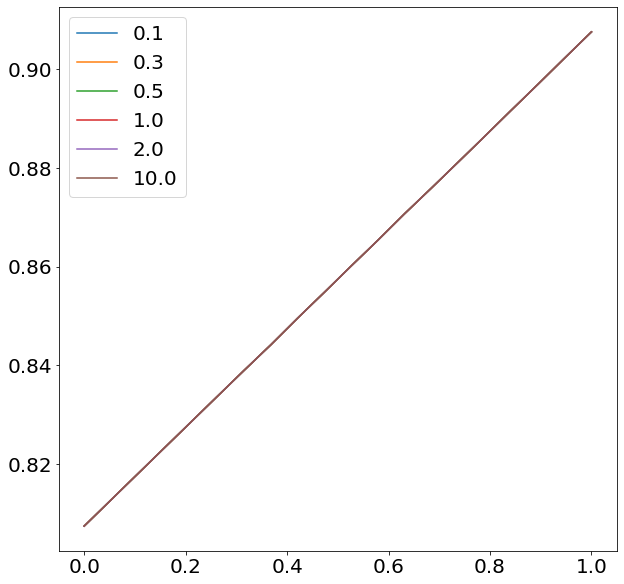

In [99]:
fig,ax = plt.subplots(figsize=(10,10))

for a in A_alloc:
    ax.plot(low_b_allocation,A_alloc[a],label=a)
ax.legend()


In [96]:
A_alloc


{0.1: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]),
 0.3: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]),
 0.5: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]),
 1.0: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]),
 2.0: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]),
 10.0: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.])}